# DBSCAN

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import DBSCAN

In [1]:
# auxilary plotting functions
def plot(X,y=None):# plot
    plt.scatter(X[:, 0], X[:, 1],c=y)
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")
    plt.show()
    


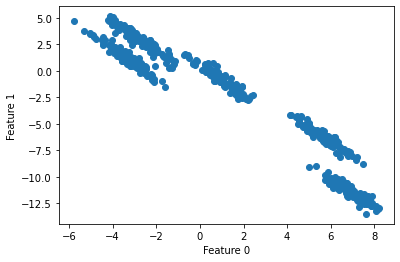

In [5]:
# generate some random cluster data
X_old, y_old = make_blobs(random_state=170, n_samples=500, centers = 5)
rng = np.random.RandomState(74)
# transform the data to be stretched
transformation = rng.normal(size=(2, 2))
X_old= np.dot(X_old, transformation)

plot(X_old)

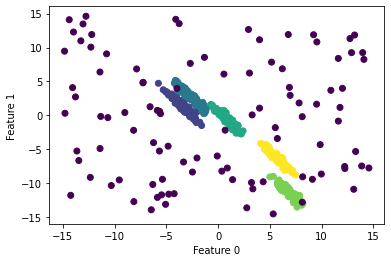

In [6]:
# Adding Noise to data
outliers = 30 * (np.random.RandomState(42).rand(100, 2) ) - 15.0
X = pd.DataFrame(np.concatenate([X_old, outliers]))
y = pd.DataFrame(np.concatenate([y_old, [-1]*len(outliers)])) #-1 are the outliers.
plot(X.values,y)

### K-Means attempt
Lets see how those outliers and non-spherical shapes affects K-Means clustreing

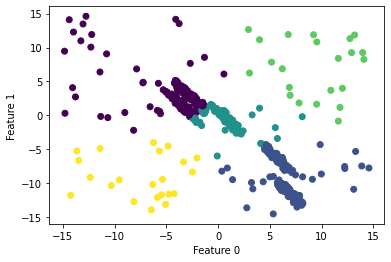

In [7]:
# cluster the data into five clusters
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)
kmeans_clusters = kmeans.predict(X)

plot(X.values,kmeans_clusters)

Not surprisingly, K-Means failed to cluster properly the data above 

DBSCAN can overcome those issues. Yet we still need to determine the parametrs...




# Estimateing $\varepsilon$


We can go over different eps values and find the one that maximizes the adjusted rand index value. In order to do so though, lets do it in a semi-supervised way: Take 50 points which are already labeled, and estimate based off of those for the rest of the data set. 

Order of operations:
1. Create an array of possible $\epsilon$ values.
2. Iterate over the different values and find the best $\epsilon$ value.
3. Visualize the results of the best one.



In [9]:
np.random.seed(0)
labeled_samples = np.random.choice(601,50,replace=False)
y.iloc[labeled_samples,0].head(10)

596   -1
52     1
190    1
165    4
344    4
342    3
441    0
406    4
389    4
243    4
Name: 0, dtype: int32

a) Create array of possible e values, and plot the best one:

0.952353787711815
0.47232323232323237


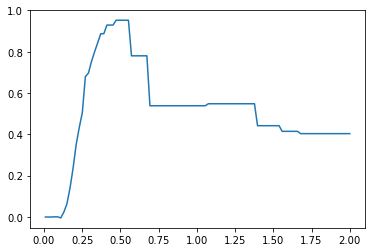

In [33]:
from sklearn.metrics import adjusted_rand_score
minPts = 4

scores = []
eps_range_50 = np.linspace(0.01, 2, 100)
for eps in eps_range_50:
    clustering = DBSCAN(eps = eps, min_samples=minPts)
    
    pred =clustering.fit_predict(X)
    scores.append(adjusted_rand_score(np.array(y.values).flatten()[labeled_samples], pred[labeled_samples]))
plt.plot(eps_range_50, scores)

print(np.max(scores))
print(eps_range_50[np.argmax(scores)])

b) Visualize the results of the best one

Text(0, 0.5, 'Feature 1')

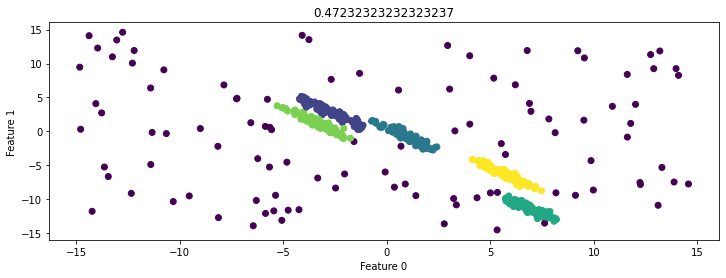

In [34]:
fig = plt.figure(figsize=(12,4))

clustering = DBSCAN(eps = eps_range_50[np.argmax(scores)], min_samples=minPts)
plt.scatter(X.values[:, 0], X.values[:, 1], c=clustering.fit(X).labels_)    
plt.title(eps_range_50[np.argmax(scores)])
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

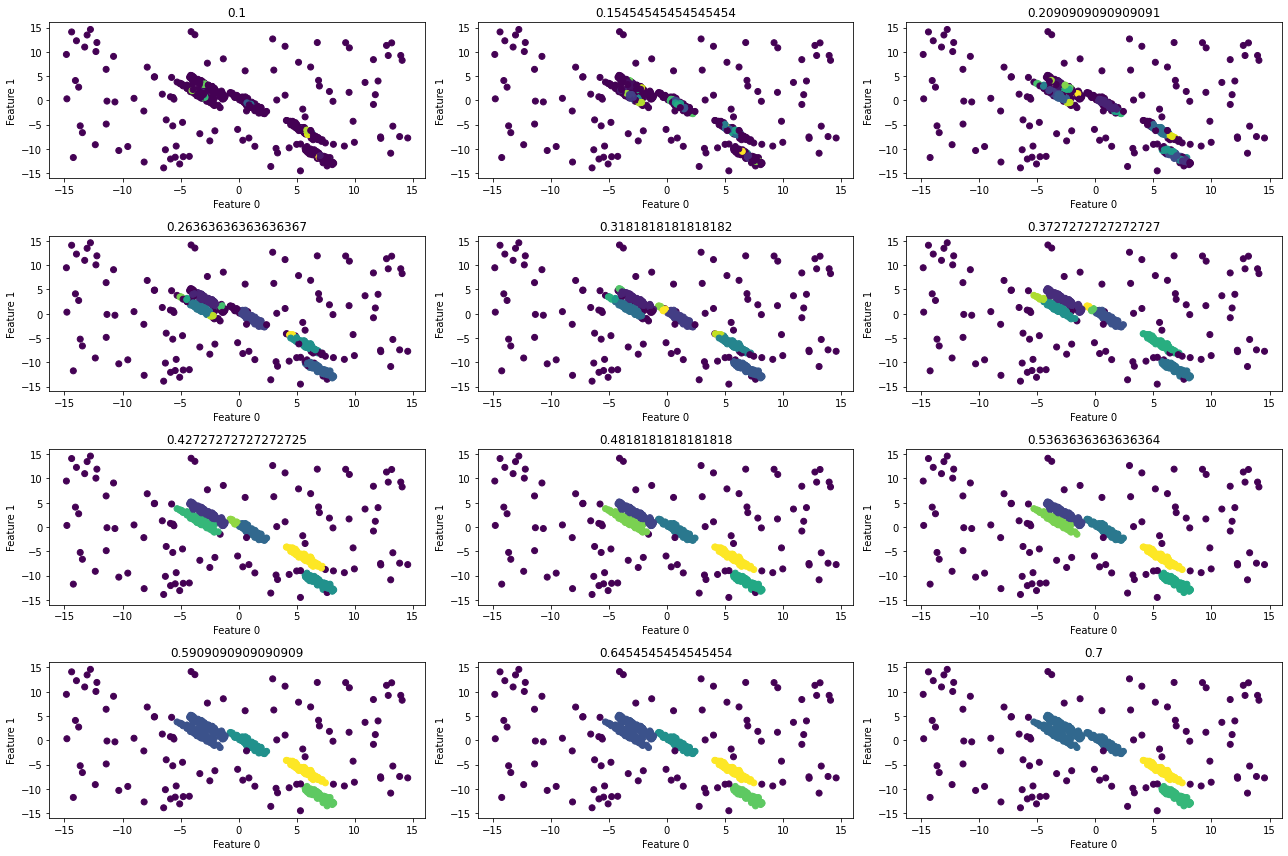

In [23]:
minPts = 4 
eps_range = np.linspace(0.1,0.7, 12)

# fig = plt.figure(figsize=(12,6))
fig = plt.figure(figsize=(18,12))

for i, eps in enumerate(eps_range):
    plt.subplot(4,3, i+1)
    clustering = DBSCAN(eps = eps, min_samples=minPts)
    plt.scatter(X.values[:, 0], X.values[:, 1], c=clustering.fit(X).labels_)    
    plt.title(eps)
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")
plt.tight_layout()

A way to narrow down the range of search for the optimal epsilon value, could be to use k nearest nieghbors. We would caluculate the distance to the nearest n points for each point, sorting and plotting the results. Then we look for the elbow of the plot, and any other pronounced changes- from these two points, we could create a  range of epsilon values.

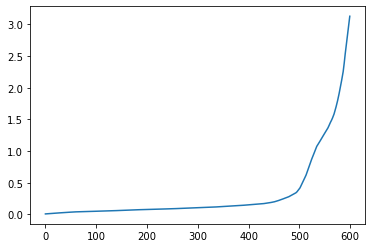

In [24]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=50)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis = 0)
distances = distances[:, 1] #(only care for the second column, first column is just 0's)
from scipy.signal import savgol_filter #Can help us to smooth the plot
distances = savgol_filter(distances, 21, 1) # Smooth the data
plt.plot(distances)

## Optimizing DBSCAN


Support yout findings by plotting the Purity score.
Implement the purity score and print the score for the best epsilon you have found.
Print the results for:
1. The small labeled set you were given
2. The rest of the data (not including the set from 1)
3. The whole data together

Are we overfitting?

In [25]:
import numpy as np
from sklearn.metrics.cluster import contingency_matrix

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    CM = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(CM, axis=0)) / np.sum(CM) 

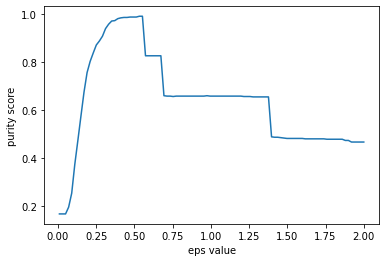

In [26]:
purity_scores = []
for eps in eps_range_50:
    clustering = DBSCAN(eps = eps, min_samples=minPts)
    purity = purity_score(y, clustering.fit(X).labels_)
    purity_scores.append(purity)
    plt.xlabel('eps value')
    plt.ylabel('purity score')
plt.plot(eps_range_50, purity_scores)


In [27]:
print('eps with best purity: ', eps_range_50[np.argmax(purity_scores)])
print('eps with best rand_index score: ', eps_range_50[np.argmax(scores)])

eps with best purity:  0.5326262626262627
eps with best rand_index score:  1.2562626262626264


#### Max purity Score by various sample sets:

In [28]:
purity_eps = eps_range_50[np.argmax(purity_scores)]
purity_score = DBSCAN(eps = purity_eps, min_samples = minPts)
prediction = purity_score.fit_predict(X)

Text(0.5, 1.0, 'Actual values')

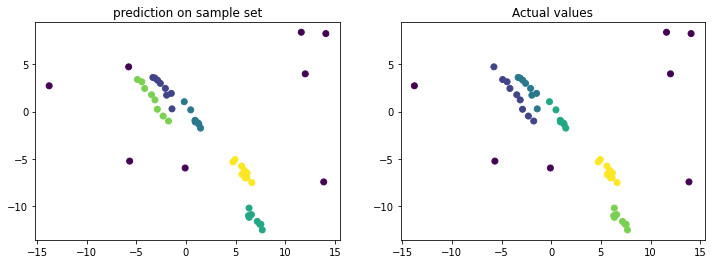

In [29]:
fig = plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.scatter(X.iloc[labeled_samples].values[:,0], X.iloc[labeled_samples].values[:,1], c = prediction[labeled_samples] )
plt.title('prediction on sample set')

plt.subplot(1,2,2)
plt.scatter(X.iloc[labeled_samples].values[:,0], X.iloc[labeled_samples].values[:,1], c = y.iloc[labeled_samples])
plt.title('Actual values')

Text(0.5, 1.0, 'Actual values')

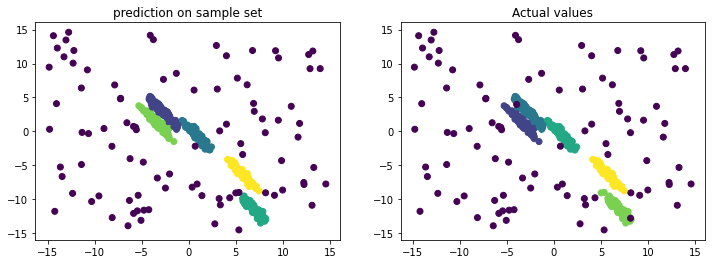

In [30]:
other_than_samp = X.drop(labeled_samples).index
fig = plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.scatter(X.iloc[other_than_samp].values[:,0], X.iloc[other_than_samp].values[:,1], c = prediction[other_than_samp] )
plt.title('prediction on sample set')

plt.subplot(1,2,2)
plt.scatter(X.iloc[other_than_samp].values[:,0], X.iloc[other_than_samp].values[:,1], c = y.iloc[other_than_samp])
plt.title('Actual values')

Text(0.5, 1.0, 'prediction on full set')

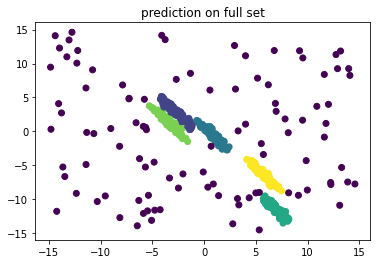

In [32]:
plt.scatter(X.values[:, 0], X.values[:, 1], c=prediction)  
plt.title('prediction on full set')  

Our model is not overfitted. With minPts = 50, we in fact are underfitting the clusters, as even the best purity score and rand index do not succeed in fully detecting one of the clusters.